## Comparison Pre&Post Data

In this part we compare our inital results with our final results.

In [4]:
import numpy as np
import sklearn as sklearn
from sklearn import linear_model
import openpyxl
import csv
import math
from scipy.stats import norm

#This code is the same as the 2ParamMIRT.ipynb code for the first section, as we need to train our model again.

np.set_printoptions(suppress=True, precision=10)

# Loading the themes
themes = ['castling', 'sacrifice', 'mateIn3', 'capturingDefender', 'doubleCheck', 'Bishop', 'mateIn4', 'clearance', 'enPassant', 'hangingPiece', 'exposedKing', 'opening', 'deflection', 'intermezzo', 'fork', 'crushing', 'advancedPawn', 'King', 'endgame', 'Pawn', 'Rook', 'promotion', 'mateIn2', 'Queen', 'trappedPiece', 'pin', 'skewer', 'xRayAttack', 'discoveredAttack', 'middlegame', 'interference', 'advantage', 'defensiveMove', 'attraction', 'mateIn5', 'kingsideAttack', 'Knight', 'queensideAttack']
excluded_themes = [] 
themesWithoutExcludedThemes = [theme for theme in themes if theme not in excluded_themes]

filenames = [['Participant1_1300/Participant1_InitialIDs1300_solved.xlsx'],
                ['Participant1_1300/Participant1_FinalPuzzles_solved.xlsx'],
                ['Participant2_1950/Participant2_InitialIDs1950_solved.xlsx'], 
                ['Participant2_1950/Participant2_FinalPuzzles_solved.xlsx'], 
                ['Participant3_1750/Participant3_InitialIDs1750_solved.xlsx'], 
                ['Participant3_1750/Participant3_FinalPuzzles_solved.xlsx'], 
                ['Participant4_1800/Participant4_InitialIDs1800_solved.xlsx'],
                ['Participant4_1800/Participant4_FinalPuzzles_solved.xlsx']]
csvFilenames = [['Participant1_1300/Participant1_InitialPuzzles_1300.csv'],
                ['Participant1_1300/Participant1_FinalPuzzles.csv'],
                ['Participant2_1950/Participant2_InitialPuzzles_1950.csv'], 
                ['Participant2_1950/Participant2_FinalPuzzles.csv'], 
                ['Participant3_1750/Participant3_InitialPuzzles_1750.csv'], 
                ['Participant3_1750/Participant3_FinalPuzzles.csv'], 
                ['Participant4_1800/Participant4_InitialPuzzles_1800.csv'],
                ['Participant4_1800/Participant4_FinalPuzzles.csv']]

playerAbilities = []
playerAbilitiesNotNormalized = []
playerNames = []
previousPlayerRatings = []

for k in range(len(filenames)):

    candidateName = filenames[k][0].split('_')[0]
    playerNames.append(candidateName)

    completedPuzzles = []
    y_Row = []
    for i in range(len(filenames[k])):
        wb = openpyxl.load_workbook(filenames[k][i])
        sheet = wb.active
        data = []


        for row in sheet.iter_rows(values_only=True):
            data.append(list(row))

        y_Row_Pre = []
        for row in data[1:]:
            y_Row_Pre.append(row[1])

        initialPuzzles = []
        with open(csvFilenames[k][i], newline='') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',', quotechar='"')
            for row in spamreader:
                initialPuzzles.append(row)
        initialPuzzles.remove(initialPuzzles[0])

        for i in range(len(y_Row_Pre)):
            if(y_Row_Pre[i] == 0 or y_Row_Pre[i] == 1):
                completedPuzzles.append(initialPuzzles[i])
                y_Row.append(y_Row_Pre[i])

    extremeCounter = 2 #extremeCounter/2 easy and hard tasks (0 and 1)
    #print(extremeCounter)

    X_Matrix = np.zeros(shape=(len(y_Row) + extremeCounter * len(themesWithoutExcludedThemes),(len(themesWithoutExcludedThemes) + 1)))

    for i in range(len(completedPuzzles)):
        filtered_themes = [theme.strip(" '") for theme in completedPuzzles[i][10].strip("[]").split(',') if theme.strip(" '") in themesWithoutExcludedThemes]
        filtered_theme_count = len(filtered_themes)
        X_Matrix[i][len(themesWithoutExcludedThemes)] = int(completedPuzzles[i][3])
        for j in range(len(themesWithoutExcludedThemes) ):
            if(themesWithoutExcludedThemes[j] in completedPuzzles[i][10]):
                X_Matrix[i][j] = float(1) / filtered_theme_count

    taskMean = np.sum([float(puzzle[3]) for puzzle in completedPuzzles]) / len(completedPuzzles)

    previousPlayerRating = taskMean + np.sum([result * 10 - 5 for result in y_Row]) #weighting the taskDifficulty doesn't make a difference, such as (difficulty/mean)*3 + 2 for correct answers


    for j in range(extremeCounter):
        for i in range(len(themesWithoutExcludedThemes)):
            if(j % 2 == 0):
                X_Matrix[len(completedPuzzles)+ j*(len(themesWithoutExcludedThemes)) + i][len(themesWithoutExcludedThemes)] = 0.5 * taskMean
                y_Row.append(1)
            else:
                X_Matrix[len(completedPuzzles)+ j*(len(themesWithoutExcludedThemes)) + i][len(themesWithoutExcludedThemes)] = 2 * taskMean
                y_Row.append(0)
            X_Matrix[len(completedPuzzles)+ j*(len(themesWithoutExcludedThemes)) + i][i] = 1

    #for i in range(len(X_Matrix)):
    #    print(X_Matrix[i], "\t\t", y_Row[i])

    logReg = linear_model.LogisticRegression(C=1e+3, fit_intercept=False, max_iter=100000)
    logReg.fit(X_Matrix, y_Row)
    weights = logReg.coef_[0]

    abilities = []
    #a is negative and we say a > 0, so take absolute value, leaving us with the same results if we take the negative difficulty...
    #So an ability of -1900 should be good enough to solve a puzzle with a rating of 1950
    a = -(weights[len(themesWithoutExcludedThemes)])
    for i in range(len(themesWithoutExcludedThemes)):
        abilities.append(weights[i]/a)
    mean = np.mean(abilities)
    std = np.std(abilities)

    #print("-"*25, " RESULTS FOR 1E+3 ", "-" * 25)
    #print("Mean of Abilities:", mean)
    #print("Std of Abilities:", std)

    #print("Slope Parameter:", a)
    #for i in range(len(abilities)):
        #print("Theme: {:<25} ability: {:<20} timesOccured: {:<10} timesCorrect: {:<10}".format(themesWithoutExcludedThemes[i], round(abilities[i], 4), np.count_nonzero(X_Matrix[:,i]), np.sum(np.where(X_Matrix[:,i] != 0, y_Row, 0))))

    #print(abilities)



    #print(y_Row)
    #print(logReg.predict_proba(X_Matrix))

    #for row in X_Matrix:
    #    print(1/(1+ math.exp(-a * (np.dot(row[:-1], abilities) + row[-1]))))

    sortedIndices = np.argsort(abilities)

    sortedAbilities = np.array(abilities)[sortedIndices]
    sortedThemes = np.array(themesWithoutExcludedThemes)[sortedIndices]

    #print("-"*20, " SORTED ABILITIES ", "-" * 20)

    #for i in range(len(abilities)):
    #   print("Theme: {:<25} Ability: {:<20} timesOccured: {:<10} timesCorrect {:<10}".format(sortedThemes[i], round(sortedAbilities[i], 4), np.count_nonzero(X_Matrix[:,themesWithoutExcludedThemes.index(sortedThemes[i])]) - extremeCounter, np.sum(np.where(X_Matrix[:,themesWithoutExcludedThemes.index(sortedThemes[i])] != 0, y_Row, 0))-int(extremeCounter/2)))

    #Now we want to get a more reasonable approach. Because the player has a mean rating of about 2169 and I suspect the sub-skills to vary in a region of 30% of the mean, let's rescale the data appropriately.
    currentMin = sortedAbilities[0]
    currentMax = sortedAbilities[-1]
    currentRange = currentMax - currentMin

    playerMean = 0

    abilityRange = 0.25

    if (a > 0):
        predictedMean = mean
        playerMean = (mean + previousPlayerRating) / 2
    else:
        predictedMean = taskMean - mean
        playerMean = ((previousPlayerRating - mean) + previousPlayerRating)/2

    predictedMin = (1-abilityRange) * playerMean
    predictedMax = (1/(1-abilityRange)) * playerMean
    predictedRange = predictedMax - predictedMin
    normalizedAbilities = []

    for i in range(len(sortedAbilities)):
                #normalizedAbility = ((sortedAbilities[i] - currentMin)/currentRange) * predictedRange + predictedMin       !This is the first version, where it gets scaled to a range around the predicted Mean
                normalizedAbility = (sortedAbilities[i] + 2 * playerMean)/(2 + 1)             #!This is the second version, where we move the abilities closer to the predicted Mean
                                                                                                                            #to get rid of extreme values again (x*playerMean/(x+1)) is the amount we choose
                normalizedAbilities.append(normalizedAbility)
    '''
    for adjustmentFactor in range(10):
        normalizedAbilities = []
        if(a > 0):
            for i in range(len(sortedAbilities)):
                #normalizedAbility = ((sortedAbilities[i] - currentMin)/currentRange) * predictedRange + predictedMin       !This is the first version, where it gets scaled to a range around the predicted Mean
                normalizedAbility = (sortedAbilities[i] + adjustmentFactor * playerMean)/(adjustmentFactor + 1)             #!This is the second version, where we move the abilities closer to the predicted Mean
                                                                                                                            #to get rid of extreme values again (x*playerMean/(x+1)) is the amount we choose
                normalizedAbilities.append(normalizedAbility)
        else:  
            for i in range(len(sortedAbilities)):
                # Inverse scaling: higher original abilities get scaled down, and lower ones get scaled up
                #normalizedAbility = ((currentMax - sortedAbilities[i])/currentRange) * predictedRange + predictedMin
                normalizedAbility = (sortedAbilities[i] + adjustmentFactor * playerMean)/(adjustmentFactor + 1) 
                normalizedAbilities.append(normalizedAbility)
            normalizedAbilities = normalizedAbilities[::-1]
            sortedThemes = sortedThemes[::-1]
        if((normalizedAbilities[-1] - normalizedAbilities[0]) < 2 * abilityRange * playerMean):                             #check if new adjusted Abilities are in a range of +/- abilityRange around the PlayerMean
            break
    '''

    print("-"*30, " NORMALIZED ABILITIES ", candidateName, "-" * 30)
    print("Normalized Abilities:", normalizedAbilities)
    print("Sorted Themes:", repr(sortedThemes))
    print("Player Rating on Initial Puzzles - mean +/-5 for every right/wrong answer", previousPlayerRating)
    print("Player Mean based on initial Puzzles and LogReg:", predictedMean)
    print("Predicted PlayerRating (less extreme - using both predicted Mean and averagePuzzles):", playerMean)
    print("Mean of Normalized Abilities:", np.mean(normalizedAbilities))
    print("Std of Normalized Abilities:", np.std(normalizedAbilities))
    print("taskMean:", round(taskMean))

    for i in range(len(abilities)):
        print("Theme: {:<25} Ability: {:<20} timesOccured: {:<10} timesCorrect: {:<10}".format(sortedThemes[i], int(normalizedAbilities[i]), np.count_nonzero(X_Matrix[:,themesWithoutExcludedThemes.index(sortedThemes[i])])-extremeCounter, np.sum(np.where(X_Matrix[:,themesWithoutExcludedThemes.index(sortedThemes[i])] != 0, y_Row, 0))-int(extremeCounter/2)))
    playerAbilities.append(normalizedAbilities)
    playerAbilitiesNotNormalized.append(sortedAbilities)
    previousPlayerRatings.append(round(taskMean))
    




------------------------------  NORMALIZED ABILITIES  Participant1 ------------------------------
Normalized Abilities: [1134.5983090393465, 1137.5533452518382, 1142.3798807288154, 1145.5372816760112, 1145.840478283102, 1153.0740214126572, 1166.7209063490789, 1187.709617888992, 1208.1265104508686, 1222.7149490744034, 1226.0301776155645, 1230.4230392619409, 1231.1793229401246, 1235.2113011838317, 1235.8725795541948, 1243.448544340419, 1244.25584489817, 1244.6755953712156, 1257.41159614939, 1262.1050620049564, 1268.3321504030757, 1277.3477153626816, 1282.5560443870702, 1339.2495360415735, 1380.117328583384, 1381.9529446483605, 1382.1689412077747, 1395.1144091616009, 1410.2295983302386, 1412.1988672277848, 1414.0613942065695, 1417.5458504724986, 1419.0273693913557, 1434.5544419044033, 1444.332052742745, 1453.51828586774, 1459.8328301443323, 1661.7103369310605]
Sorted Themes: array(['queensideAttack', 'Rook', 'promotion', 'capturingDefender',
       'interference', 'advancedPawn', 'mateIn5

Plotting of the results

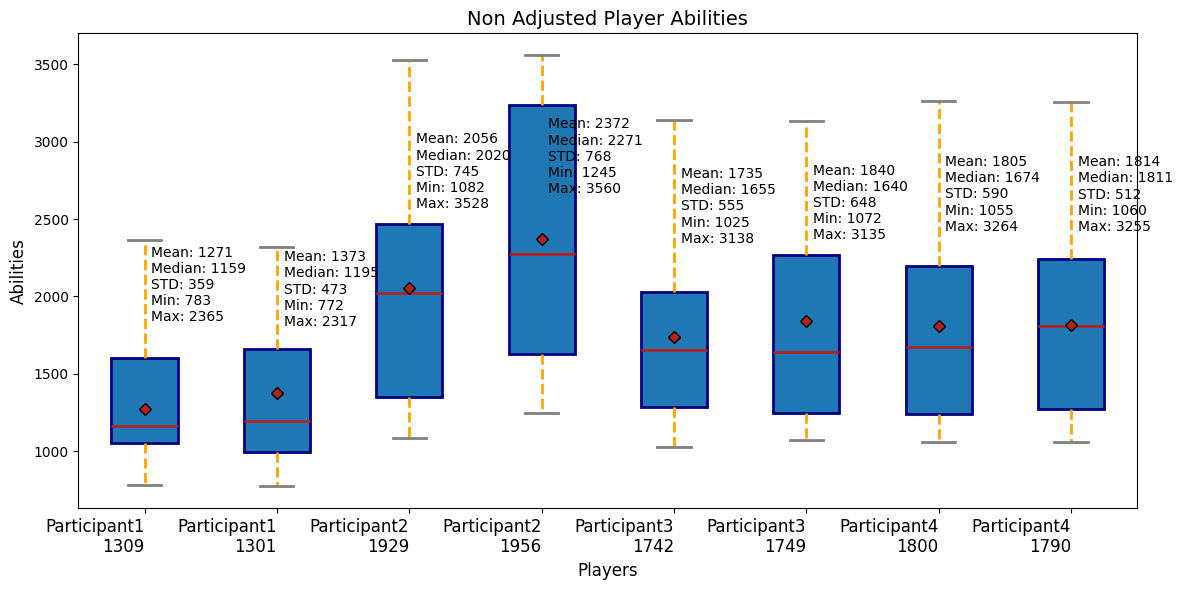

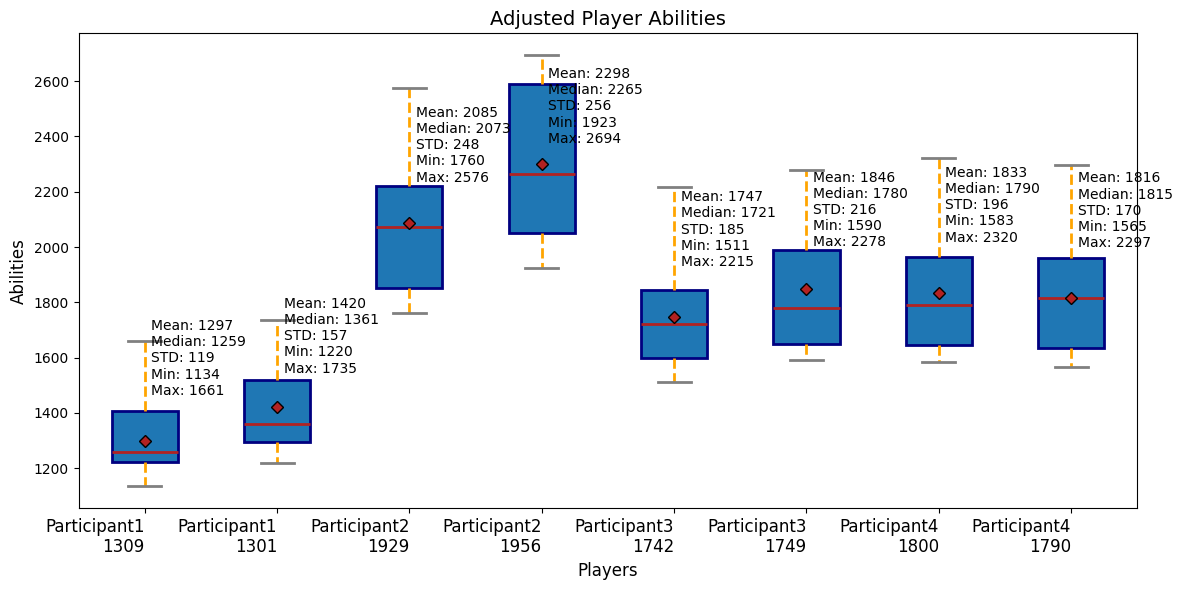

In [12]:
import matplotlib.pyplot as plt
import numpy as np



plt.figure(figsize=(12, 6))
boxprops = dict(linestyle='-', linewidth=2, color='navy')
whiskerprops = dict(linestyle='--', linewidth=2, color='orange')
medianprops = dict(linestyle='-', linewidth=2, color='firebrick')
capprops = dict(linestyle='-', linewidth=2, color='grey')
flierprops = dict(marker='o', markerfacecolor='green', markersize=8, linestyle='none')
meanpointprops = dict(marker='D', markeredgecolor='black', markerfacecolor='firebrick')

combined_labels = [f'{name}\n{rating}' for name, rating in zip(playerNames, previousPlayerRatings)]

# Create the boxplot
bp = plt.boxplot(playerAbilitiesNotNormalized, 
                 patch_artist=True, showmeans=True,
                 boxprops=boxprops, whiskerprops=whiskerprops,
                 medianprops=medianprops, capprops=capprops,
                 flierprops=flierprops, meanprops=meanpointprops)

plt.xticks(range(1, len(playerNames) + 1), combined_labels, rotation=0, fontsize=12, ha='right')
plt.yticks(fontsize=10)  # Bigger, bolder font for y-axis

# Calculate means and annotate the plot
for i, abilities in enumerate(playerAbilitiesNotNormalized):
    mean_val = (int) (np.mean(abilities))
    std_val = (int) (np.std(abilities))
    min_val = (int) (np.min(abilities))
    max_val = (int) (np.max(abilities))
    median_val = (int) (np.median(abilities))
    
    # Plot the mean
    plt.scatter(i+1, mean_val, color='darkgreen', marker='o')  
    
    # Annotate Mean, STD, Min, and Max to the right of the boxplot
    plt.text(i+1.05, (min_val + max_val) / 2 + 500, 
             f'Mean: {mean_val}\nMedian: {median_val}\nSTD: {std_val}\nMin: {min_val}\nMax: {max_val}', 
             ha='left', va='center', fontsize=10, color='black')

plt.xlabel('Players', fontsize=12)
plt.ylabel('Abilities', fontsize=12)
plt.title('Non Adjusted Player Abilities', fontsize=14)
plt.tight_layout()  # Adjust layout to fit everything neatly
plt.show()

'''
SECOND PLOT
'''

plt.figure(figsize=(12, 6))
boxprops = dict(linestyle='-', linewidth=2, color='navy')
whiskerprops = dict(linestyle='--', linewidth=2, color='orange')
medianprops = dict(linestyle='-', linewidth=2, color='firebrick')
capprops = dict(linestyle='-', linewidth=2, color='grey')
flierprops = dict(marker='o', markerfacecolor='green', markersize=8, linestyle='none')
meanpointprops = dict(marker='D', markeredgecolor='black', markerfacecolor='firebrick')

combined_labels = [f'{name}\n{rating}' for name, rating in zip(playerNames, previousPlayerRatings)]

# Create the boxplot
bp = plt.boxplot(playerAbilities, 
                 patch_artist=True, showmeans=True,
                 boxprops=boxprops, whiskerprops=whiskerprops,
                 medianprops=medianprops, capprops=capprops,
                 flierprops=flierprops, meanprops=meanpointprops)

plt.xticks(range(1, len(playerNames) + 1), combined_labels, rotation=0, fontsize=12, ha='right')
plt.yticks(fontsize=10) 

# Calculate means and annotate the plot
for j, abilities in enumerate(playerAbilities):
    mean_val = (int) (np.mean(abilities))
    std_val = (int) (np.std(abilities))
    min_val = (int) (np.min(abilities))
    max_val = (int) (np.max(abilities))
    median_val = (int) (np.median(abilities))
    
    # Plot the mean
    plt.scatter(j+1, mean_val, color='darkgreen', marker='o')  
    
    # Annotate Mean, STD, Min, and Max to the right of the boxplot
    plt.text(j+1.05, (min_val + max_val) / 2 + 200, 
             f'Mean: {mean_val}\nMedian: {median_val}\nSTD: {std_val}\nMin: {min_val}\nMax: {max_val}', 
             ha='left', va='center', fontsize=10, color='black')

plt.xlabel('Players', fontsize=12)
plt.ylabel('Abilities', fontsize=12)
plt.title('Adjusted Player Abilities', fontsize=14)
plt.tight_layout()  # Adjust layout to fit everything neatly
plt.show()

